## xLSTM - Financial data Timeseries forecasting

xLSTM was published earlier this year and has shown state-of the art restults in the LLM domain compared to transformers which dominate the field at the moment. Not much research has been conducted in timeseries data but LSTM have shown great results in a number of widely published cases.

In this notebook the aim is to use a simple implementation of xLSTM and compare the performance of "leaked-data" based prediction vs recursive prediction

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from xLSTM import sLSTM, mLSTM, xLSTM
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from sklearn.metrics import mean_absolute_error

import yfinance as yf
import datetime

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# ticker = 'AAPL'

# # Get today's date
# #end_date = datetime.datetime.today().strftime('%Y-%m-%d')
# end_date = '2024-10-04'

# # Define the start date as two years ago
# start_date = (datetime.datetime.today() - datetime.timedelta(days=730)).strftime('%Y-%m-%d')

# # Download Apple stock data for the last 2 years
# aapl = yf.download(ticker, start=start_date, end=end_date)

# # Display the first few rows of the data
# aapl.head()

In [ ]:
# Dataset hyperparameters
batch_size = 128 #64 #16
seq_len = 8

# Load and preprocess the dataset
data = pd.read_csv('data/ITC.csv', usecols=[8], engine='python')
print(data)
dataset = data.values.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.95)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

       Close
0     708.50
1     712.35
2     726.20
3     784.30
4     847.05
...      ...
5301  205.30
5302  205.40
5303  205.50
5304  204.30
5305  202.60

[5306 rows x 1 columns]


In [4]:
def create_dataset(dataset, seq_len=8):
    dataX, dataY = [], []
    for i in range(len(dataset) - seq_len):
        a = dataset[i:(i + seq_len - 1)]
        dataX.append(a)
        dataY.append(dataset[i + seq_len - 1])
    return torch.Tensor(dataX), torch.Tensor(dataY)

In [5]:
trainX, trainY = create_dataset(train, seq_len)
testX, testY = create_dataset(test, seq_len)

C:\Users\MITESH\AppData\Local\Temp\ipykernel_26504\1583257355.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  return torch.Tensor(dataX), torch.Tensor(dataY)


In [6]:
# Create data loaders
train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model hyperparameters
input_size = 1
head_size = 32
num_heads = 2

In [7]:
# Define models
models = {
    "xLSTM": xLSTM(input_size, head_size, num_heads, batch_first=True, layers='msm'),
    "LSTM": nn.LSTM(input_size, head_size, batch_first=True, proj_size= input_size),
    "sLSTM": sLSTM(input_size, head_size, num_heads, batch_first=True),
    "mLSTM": mLSTM(input_size, head_size, num_heads, batch_first=True)
}

In [8]:
# Training process
def train_model(model, model_name, epochs=100, learning_rate=0.0001):
    #criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    for epoch in tqdm(range(epochs), desc=f'Training {model_name}'):
        model.train()
        epoch_loss = 0
        for i, (inputs_, targets_) in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, targets  = inputs_.to(device), targets_.to(device)
            
            outputs, _ = model(inputs)
            outputs = outputs[:, -1, :]
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

    return model, train_losses

Training mLSTM: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


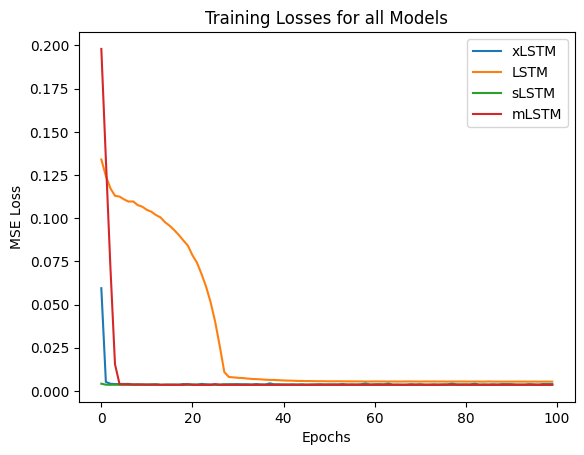

In [9]:
# Train the models
trained_models = {}
all_train_losses = {}
for model_name, model in models.items():
    trained_models[model_name], all_train_losses[model_name] = train_model(model, model_name)

# Plot losses for each model
plt.figure()
for model_name, train_losses in all_train_losses.items():
    plt.plot(train_losses, label=model_name)

# Plot all model losses compared
plt.title('Training Losses for all Models')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [10]:
def evaluate_model(model, data_loader):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs, _ = model(inputs.to(device))
            predictions.extend(outputs[:, -1, :].cpu().numpy())
    return predictions

In [11]:
prediction_input = torch.concatenate((trainX[-1,1:,...].squeeze(),trainY[-1,...]))[None,:,None]

In [28]:
def one_shot_evaluate_model(model, dataset, future = 10):
    model.to(device)
    model.eval()
    predictions = []
    dataset.to(device)
    with torch.no_grad():
        outputs, _ = model(dataset.to(device))
        predictions.extend(outputs[:, -1, :].cpu().numpy())
        new_dataset = torch.concatenate((dataset[:,1:,:].squeeze().to(device), outputs[:,-1,:].reshape(1).to(device)))[None,:,None]
        new_dataset.to(device)
        for i in range(future-1):
            outputs, _ = model(new_dataset.to(device))
            predictions.extend(outputs[:, -1, :].cpu().numpy())
            new_dataset = torch.concatenate((dataset[:,1:,:].squeeze().to(device), outputs[:,-1,:].reshape(1).to(device)))[None,:,None]
            #new_dataset = outputs
    return predictions

The recursive predictions perform poorly for all the models. This can be due to a number of reasons:
* Not enough training data/epochs and the training does not yet involve recursive prediction during training
* The model uses only a single LSTM layer, it may require more layers to capture all the features/dependencies. More layers will significantly increase the training time
* The number of hidden features is too low for a recursive prediction


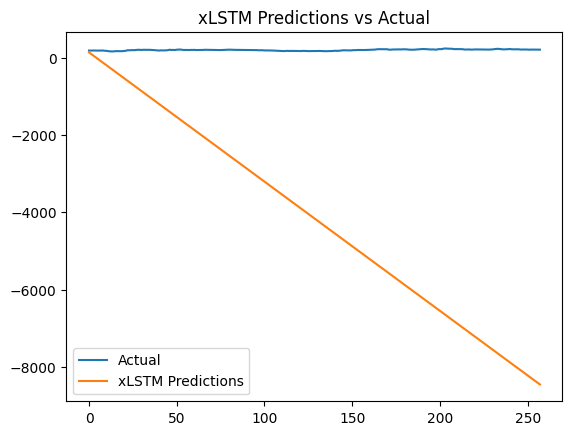

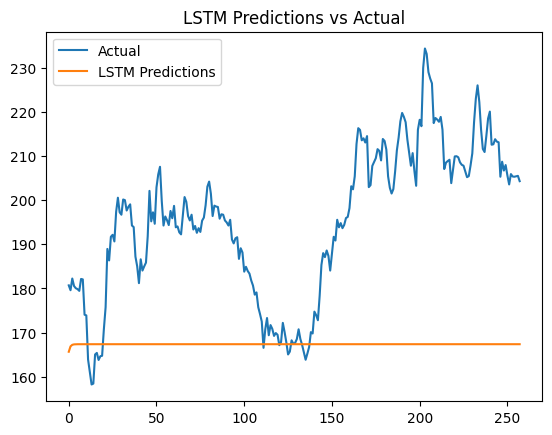

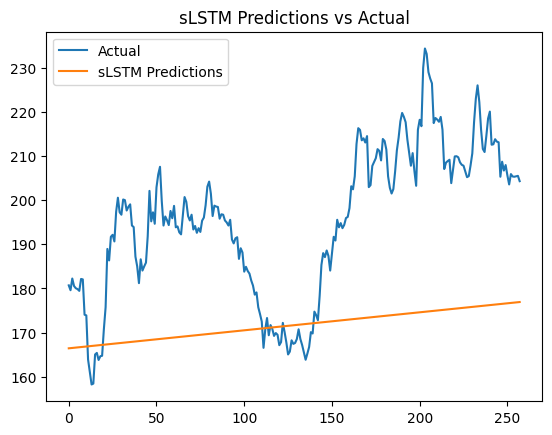

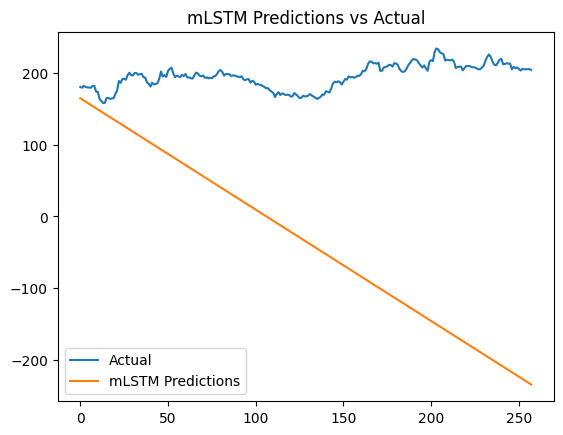

In [29]:
test_predictions_oneshot = {}
for model_name, model in trained_models.items():
    test_predictions_oneshot[model_name] = one_shot_evaluate_model(model, prediction_input, future = 258)
final_dict = {}
# Plot predictions for each model
for model_name, preds in test_predictions_oneshot.items():
    # Inverse transform the predictions and actual values
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    actual = scaler.inverse_transform(testY.numpy().reshape(-1, 1))
    final_dict[model_name] = preds
    plt.figure()
    plt.plot(actual, label='Actual')
    plt.plot(preds, label=model_name + ' Predictions')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.legend()
    plt.show()

Below the same set of models are used to predict the future but it is given a sample of unseen data to forecast the next point

We can see that the "leaked-data" based predictions perform very well, this is expected as it is what the model was trained for. However, it means the model has a very narrow use-case as it can only predict a single time unit forward. 

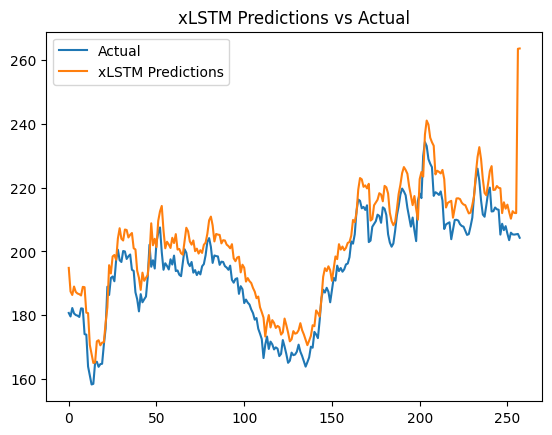

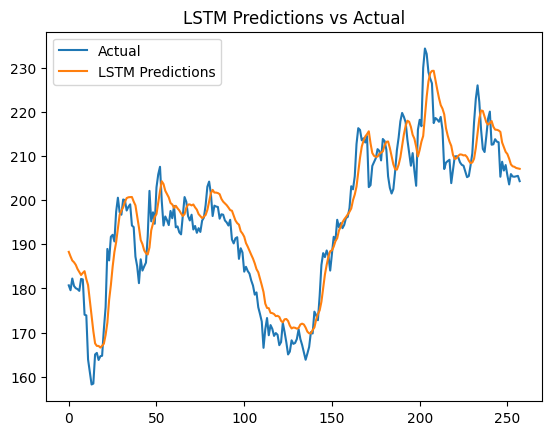

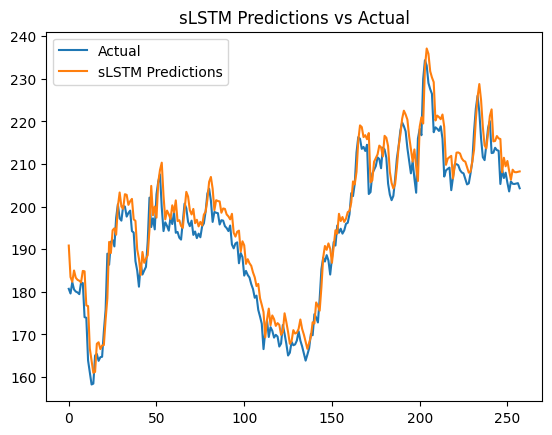

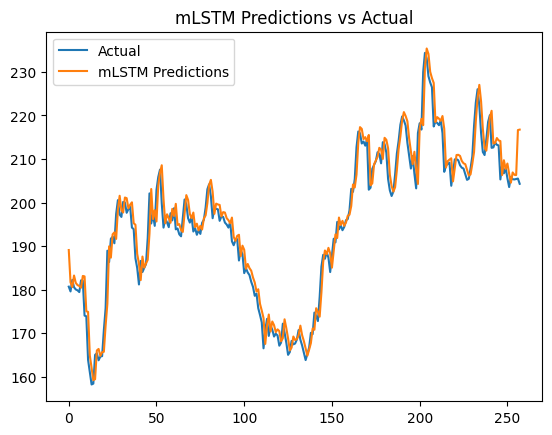

In [14]:
test_predictions = {}
for model_name, model in trained_models.items():
    test_predictions[model_name] = evaluate_model(model, test_loader)
final_dict = {}
# Plot predictions for each model
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions and actual values
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    actual = scaler.inverse_transform(testY.numpy().reshape(-1, 1))
    final_dict[model_name] = preds
    plt.figure()
    plt.plot(actual, label='Actual')
    plt.plot(preds, label=model_name + ' Predictions')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.legend()
    plt.show()

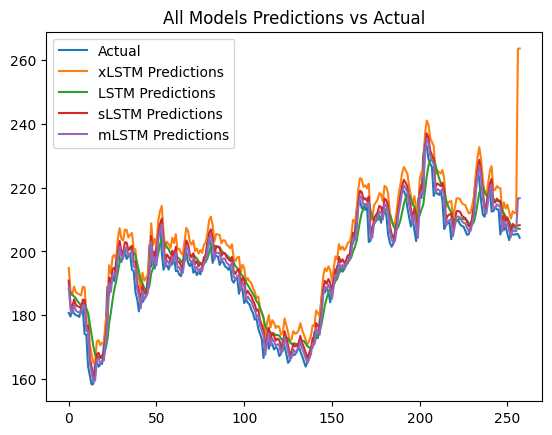

xLSTM : 7.274550437927246
LSTM : 4.712963581085205
sLSTM : 3.5956904888153076
mLSTM : 2.847294569015503


In [15]:
# Plot all model predictions compared
plt.figure()
plt.plot(actual, label='Actual')
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    plt.plot(preds, label=model_name + ' Predictions')

plt.title('All Models Predictions vs Actual')
plt.legend()
plt.show()

for i in final_dict:
    print(f"{i} : {mean_absolute_error(actual, final_dict[i])}")

This notebook has shown that a basic xLSTM model performs well for a single forward data point prediction but struggles with recursive prediction. Further work will involve expanding the xLSTM model to stabalise and improve the recursive prediciton.